# **유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
path = '/content/drive/MyDrive/KT Aivle/Mini Project 6-1/'

### **(2) 라이브러리 설치 및 불러오기**

In [4]:
!pip install workalendar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=6ab65ea8e939d568cd21187d4463f9a5f66c393e2354bf0a226c3687b841a9d7
  Stored in directory: /root/.cache/pip/wheels/d6/67/78/aa2e8d108639dd23a5e9e72a4fc88bb44f5541894382712f48
Successfully built pymeeus


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from workalendar.usa import Minnesota

import warnings
warnings.filterwarnings("ignore")

In [6]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [27]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [28]:
products.head(1)

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50


In [29]:
stores.head(1)

,Store_ID,City,State,Store_Type
0,1,Saint Paul,\tMinnesota,4


# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [30]:
def my_new_df(Product_ID, Store_ID=44):
    sort_oil_price = oil_price.sort_values(by='Date')
    sort_orders = orders.sort_values(by='Date')
    sort_sales = sales.sort_values(by='Date')

    orders_SID = sort_orders.loc[sort_orders['Store_ID'] == Store_ID]
    sales_SID = sort_sales.loc[sort_sales['Store_ID'] == Store_ID]

    sales_SID_PID = sales_SID.loc[sales['Product_ID'] == Product_ID]
    df = pd.merge(sales_SID_PID, orders_SID, how='left', on='Date')
    df.dropna(inplace=True)
    df = pd.merge(df, oil_price, how='left', on='Date')
    df.drop(columns=['Store_ID_y'], inplace=True)
    df.rename(columns={'Store_ID_x': 'Store_ID'}, inplace=True)

    df = pd.merge(df, products, how='left', on='Product_ID')
    df = pd.merge(df, stores, how='left', on='Store_ID')

    # 1: 처리가 애매한 결측치 제거
    df = df[1:]
    # 시계열 데이터이니 선형 보간
    df['WTI_Price'] = df['WTI_Price'].interpolate(method='linear')

    product_info = products.loc[products['Product_ID'] == Product_ID]
    lead_time = product_info['LeadTime'].values[0]

    df['TARGET'] = df['Qty'].shift(-lead_time)
    # :-lead_time TARGET 생성으로 인해 파생된 결측치 제거
    df = df[:-lead_time]

    # NEW 리드 타임 기간 이전의 판매량
    df['PreviousLeadTime'] = df['Qty'].shift(lead_time)
    # lead_time: PreviousLeadTime 생성으로 인해 파생된 결측치 제거
    df = df[lead_time:]
    df.reset_index(inplace=True)
    df = df[['Date', 'Qty', 'CustomerCount', 'WTI_Price', 'PreviousLeadTime', 'TARGET']]

    # NEW
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Week'] = df['Date'].dt.dayofweek
    df['Weekend'] = df['Date'].dt.dayofweek // 5

    cal = Minnesota()
    holiday = pd.DataFrame()
    for y in range(2014, 2018) :
        holiday = pd.concat([holiday, pd.DataFrame(cal.holidays(y))], axis = 0)

    holiday.columns = ['Date', 'holiday']
    holiday['Date'] = pd.to_datetime(holiday['Date'])
    holiday['holiday'] = 1
    df = pd.merge(df, holiday, how='left', on='Date')
    df['holiday'] = np.where(df['holiday'].isna(), 0, 1)
    # 3·4·5월을 봄:0, 6·7·8월을 여름:1, 9·10·11월을 가을:2, 12·1·2월을 겨울:3
    season_mapping = {
        3: 0, 4: 0, 5: 0,  # 봄
        6: 1, 7: 1, 8: 1,  # 여름
        9: 2, 10: 2, 11: 2,  # 가을
        12: 3, 1: 3, 2: 3  # 겨울
    }
    df['Season'] = df['Month'].map(season_mapping)
    return df

## **(1) 상품 : 3 - Beverage**

In [31]:
df_beverage = my_new_df(3)
df_beverage

,Date,Qty,CustomerCount,WTI_Price,PreviousLeadTime,TARGET,Year,Month,Day,Week,Weekend,holiday,Season
0,2014-01-05,15606.0,5123.0,93.300000,8647.0,7188.0,2014,1,5,6,1,0,3
1,2014-01-06,7900.0,3917.0,93.120000,15153.0,8800.0,2014,1,6,0,0,0,3
2,2014-01-07,7188.0,3663.0,93.310000,15606.0,6606.0,2014,1,7,1,0,0,3
3,2014-01-08,8800.0,4254.0,91.900000,7900.0,7051.0,2014,1,8,2,0,0,3
4,2014-01-09,6606.0,3723.0,91.360000,7188.0,12599.0,2014,1,9,3,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,2017-02-22,7856.0,3834.0,53.610000,6004.0,10208.0,2017,2,22,2,0,0,3
1137,2017-02-23,8018.0,3955.0,54.480000,7177.0,12361.0,2017,2,23,3,0,0,3
1138,2017-02-24,10208.0,4549.0,53.990000,7856.0,10108.0,2017,2,24,4,0,0,3
1139,2017-02-25,12361.0,4619.0,54.006667,8018.0,10006.0,2017,2,25,5,1,0,3


## **(2) 상품 : 12 - Milk**

In [32]:
df_milk = my_new_df(12)
df_milk

,Date,Qty,CustomerCount,WTI_Price,PreviousLeadTime,TARGET,Year,Month,Day,Week,Weekend,holiday,Season
0,2014-01-05,14490.0,5123.0,93.300000,8879.0,7124.0,2014,1,5,6,1,0,3
1,2014-01-06,7614.0,3917.0,93.120000,14188.0,8683.0,2014,1,6,0,0,0,3
2,2014-01-07,7124.0,3663.0,93.310000,14490.0,6731.0,2014,1,7,1,0,0,3
3,2014-01-08,8683.0,4254.0,91.900000,7614.0,6992.0,2014,1,8,2,0,0,3
4,2014-01-09,6731.0,3723.0,91.360000,7124.0,11224.0,2014,1,9,3,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,2017-02-22,8931.0,3834.0,53.610000,7246.0,10630.0,2017,2,22,2,0,0,3
1137,2017-02-23,8643.0,3955.0,54.480000,7374.0,12978.0,2017,2,23,3,0,0,3
1138,2017-02-24,10630.0,4549.0,53.990000,8931.0,10899.0,2017,2,24,4,0,0,3
1139,2017-02-25,12978.0,4619.0,54.006667,8643.0,10618.0,2017,2,25,5,1,0,3


## **(3) 상품 : 42 - Agricultural products**

In [33]:
df_agricultural = my_new_df(42)
df_agricultural

,Date,Qty,CustomerCount,WTI_Price,PreviousLeadTime,TARGET,Year,Month,Day,Week,Weekend,holiday,Season
0,2014-01-05,88.0,5123.0,93.300000,74.0,78.0,2014,1,5,6,1,0,3
1,2014-01-06,65.0,3917.0,93.120000,78.0,73.0,2014,1,6,0,0,0,3
2,2014-01-07,78.0,3663.0,93.310000,88.0,78.0,2014,1,7,1,0,0,3
3,2014-01-08,73.0,4254.0,91.900000,65.0,96.0,2014,1,8,2,0,0,3
4,2014-01-09,78.0,3723.0,91.360000,78.0,67.0,2014,1,9,3,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136,2017-02-22,72.0,3834.0,53.610000,76.0,91.0,2017,2,22,2,0,0,3
1137,2017-02-23,98.0,3955.0,54.480000,94.0,105.0,2017,2,23,3,0,0,3
1138,2017-02-24,91.0,4549.0,53.990000,72.0,108.0,2017,2,24,4,0,0,3
1139,2017-02-25,105.0,4619.0,54.006667,98.0,78.0,2017,2,25,5,1,0,3


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


In [34]:
TARGET = 'TARGET'

In [35]:
def my_train_test(df):
    x = df.drop(columns=[TARGET, 'Date'], axis=1)
    y = df.loc[:, TARGET]

    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    y_max, y_min = y.max(), y.min()
    y = (y - y_min) / (y_max - y_min)

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=60, shuffle=False)
    return x_train, x_val, y_train, y_val

In [36]:
def my_DNN_model(x_train, x_val, y_train, y_val):
    clear_session()

    model = Sequential([
        Input(shape=(x_train.shape[1], ))
        , Dense(1)
    ])
    model.summary()

    model.compile(optimizer='adam', loss='mse')
    es = EarlyStopping(
        monitor="val_loss"
        , patience=5
        , restore_best_weights=True
    )
    history = model.fit(x_train, y_train, epochs=500, validation_split=.2, callbacks=[es], verbose=0).history
    dl_history_plot(history)
    pred = model.predict(x_val)
    plot_model_result(y_train, y_val, pred)

    print("RMSE:", mean_squared_error(y_val, pred, squared=True))
    print("MAE:", mean_absolute_error(y_val, pred))
    print("MAPE:", mean_absolute_percentage_error(y_val, pred))
    print("R2:", r2_score(y_val, pred))

## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [37]:
x_train_b, x_val_b, y_train_b, y_val_b = my_train_test(df_beverage)

### **2) 모델링**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


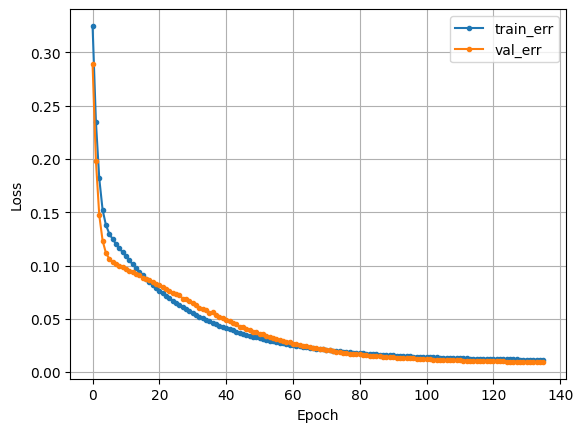

2/2 [==============================] - 0s 4ms/step


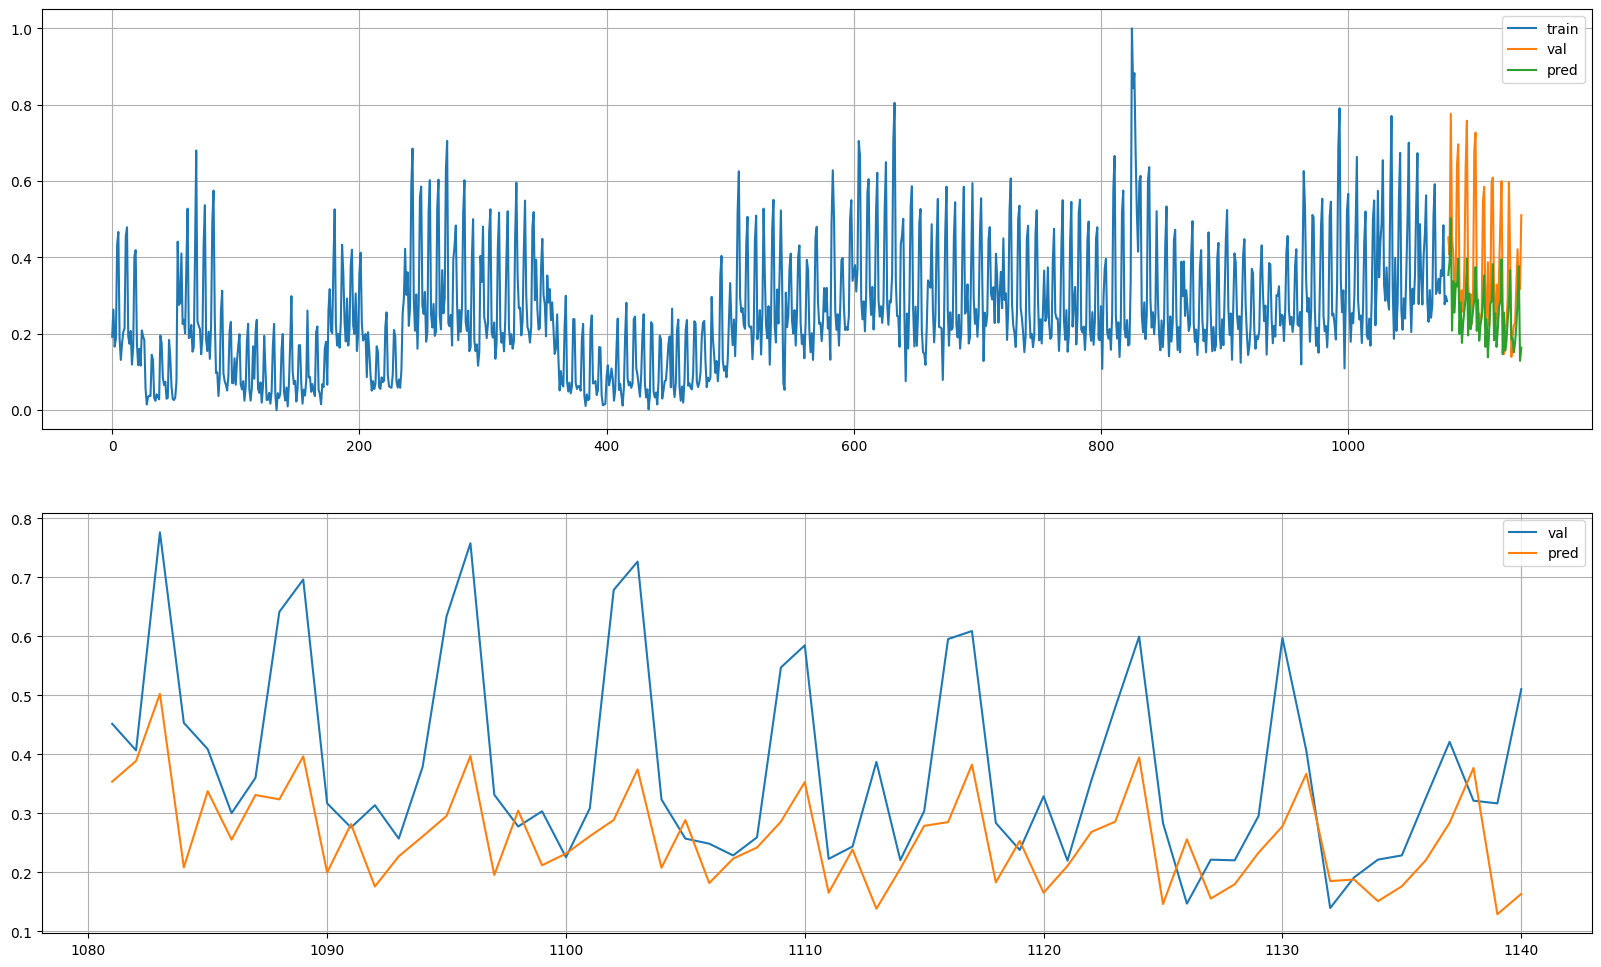

In [38]:
my_DNN_model(x_train_b, x_val_b, y_train_b, y_val_b)

## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [39]:
x_train_m, x_val_m, y_train_m, y_val_m = my_train_test(df_milk)

RMSE: 0.029389374435761027
MAE: 0.1287611120315731
MAPE: 0.29918021673618783
R2: -0.09198680459822972


### **2) 모델링**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


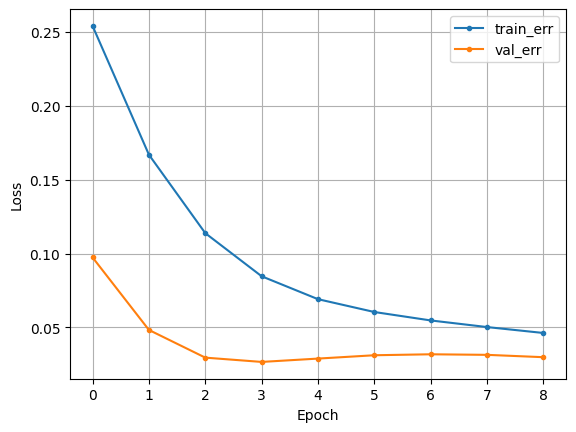

2/2 [==============================] - 0s 6ms/step


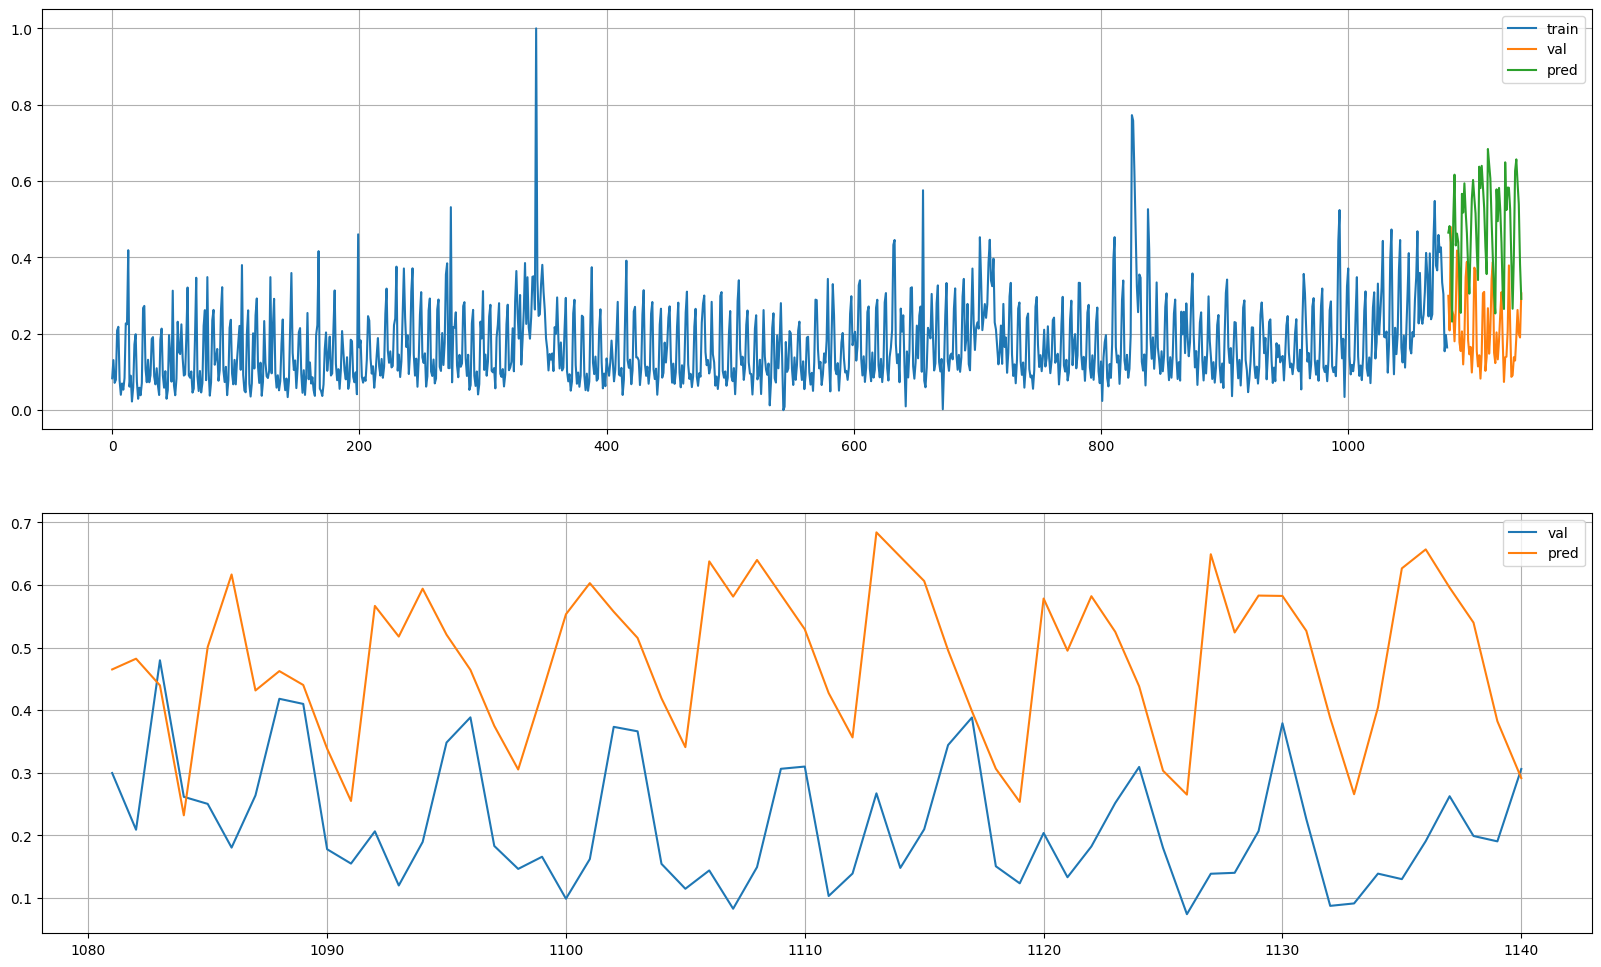

RMSE: 0.09083736509424874
MAE: 0.265567633004732
MAPE: 1.6502261606539002
R2: -8.46750684091573


In [40]:
my_DNN_model(x_train_m, x_val_m, y_train_m, y_val_m)

## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [41]:
x_train_a, x_val_a, y_train_a, y_val_a = my_train_test(df_agricultural)

### **2) 모델링**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


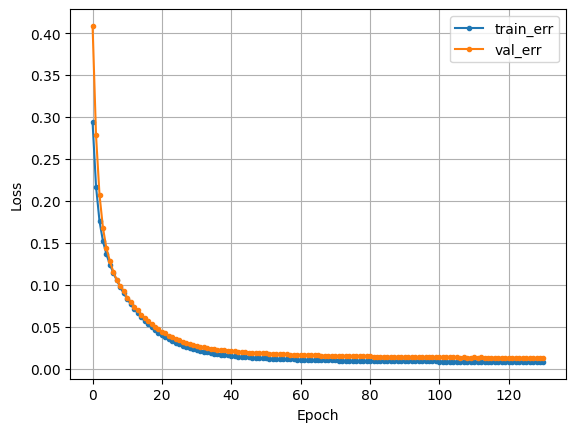

2/2 [==============================] - 0s 5ms/step


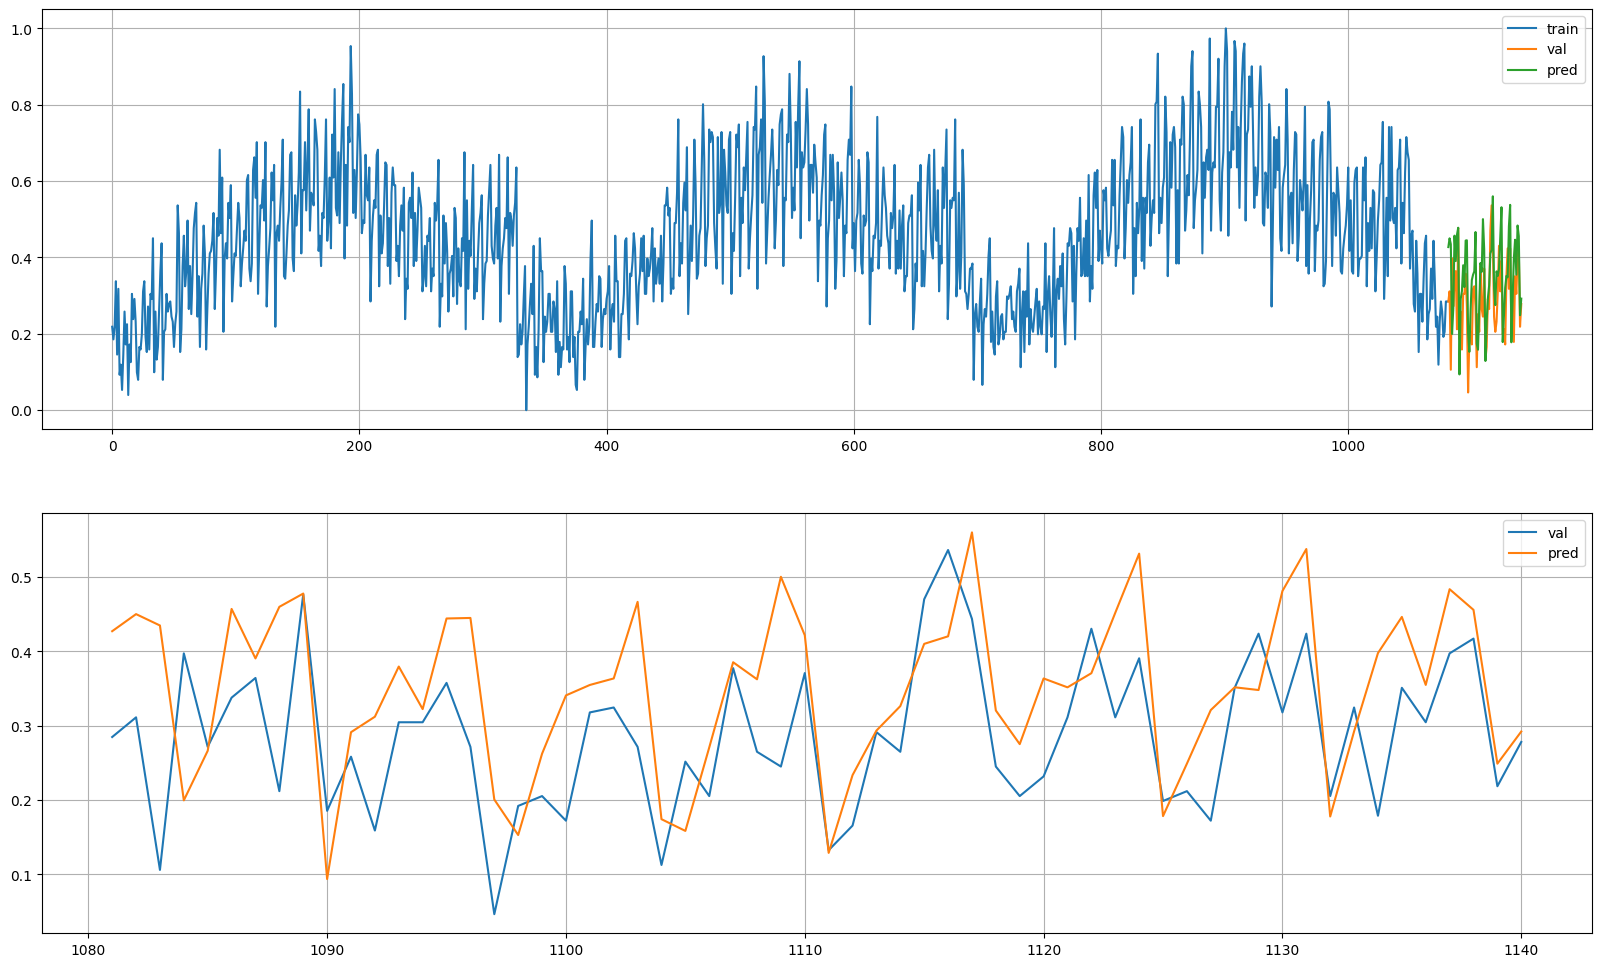

RMSE: 0.01307761527065662
MAE: 0.09001920392231041
MAPE: 0.4261222825033684
R2: -0.2964841261467357


In [42]:
my_DNN_model(x_train_a, x_val_a, y_train_a, y_val_a)

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [43]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [44]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [45]:
def my_train_test_3(df):
    x = df.drop(columns=[TARGET, 'Date'], axis=1)
    y = df.loc[:, TARGET]

    timestep = 7
    x, y = temporalize(x, y, timestep)

    scaler = MinMaxScaler().fit(flatten(x))
    x = scale(x, scaler)

    # scaler = MinMaxScaler()
    # y = scaler.fit_transform(y.reshape(-1,1))

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=60, shuffle=False)
    return x_train, x_val, y_train, y_val

In [46]:
def my_LSTM_model(x_train, x_val, y_train, y_val):
    clear_session()

    model = Sequential([
        Input(shape=(x_train.shape[1], x_train.shape[2]))
        , LSTM(7, activation='relu')
        , Dense(1)
    ])

    model.summary()
    model.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(
        monitor="val_loss"
        , patience=5
        , restore_best_weights=True
    )
    history = model.fit(x_train, y_train, epochs=500, validation_split=.2, callbacks=[es], verbose=0).history
    dl_history_plot(history)
    pred = model.predict(x_val)
    plot_model_result(y_train, y_val, pred)

    print("RMSE:", mean_squared_error(y_val, pred, squared=True))
    print("MAE:", mean_absolute_error(y_val, pred))
    print("MAPE:", mean_absolute_percentage_error(y_val, pred))
    print("R2:", r2_score(y_val, pred))

## **(1) LSTM 초기 모델링**

In [47]:
TARGET = 'TARGET'

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [48]:
x_train_b, x_val_b, y_train_b, y_val_b = my_train_test_3(df_beverage)

* **모델링**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7)                 532       
                                                                 
 dense (Dense)               (None, 1)                 8         
                                                                 
Total params: 540 (2.11 KB)
Trainable params: 540 (2.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


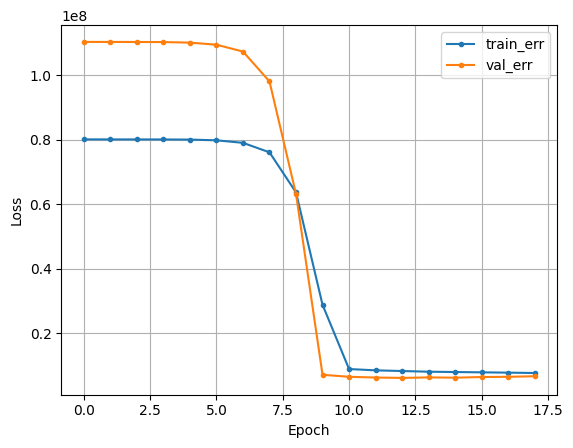

2/2 [==============================] - 0s 7ms/step


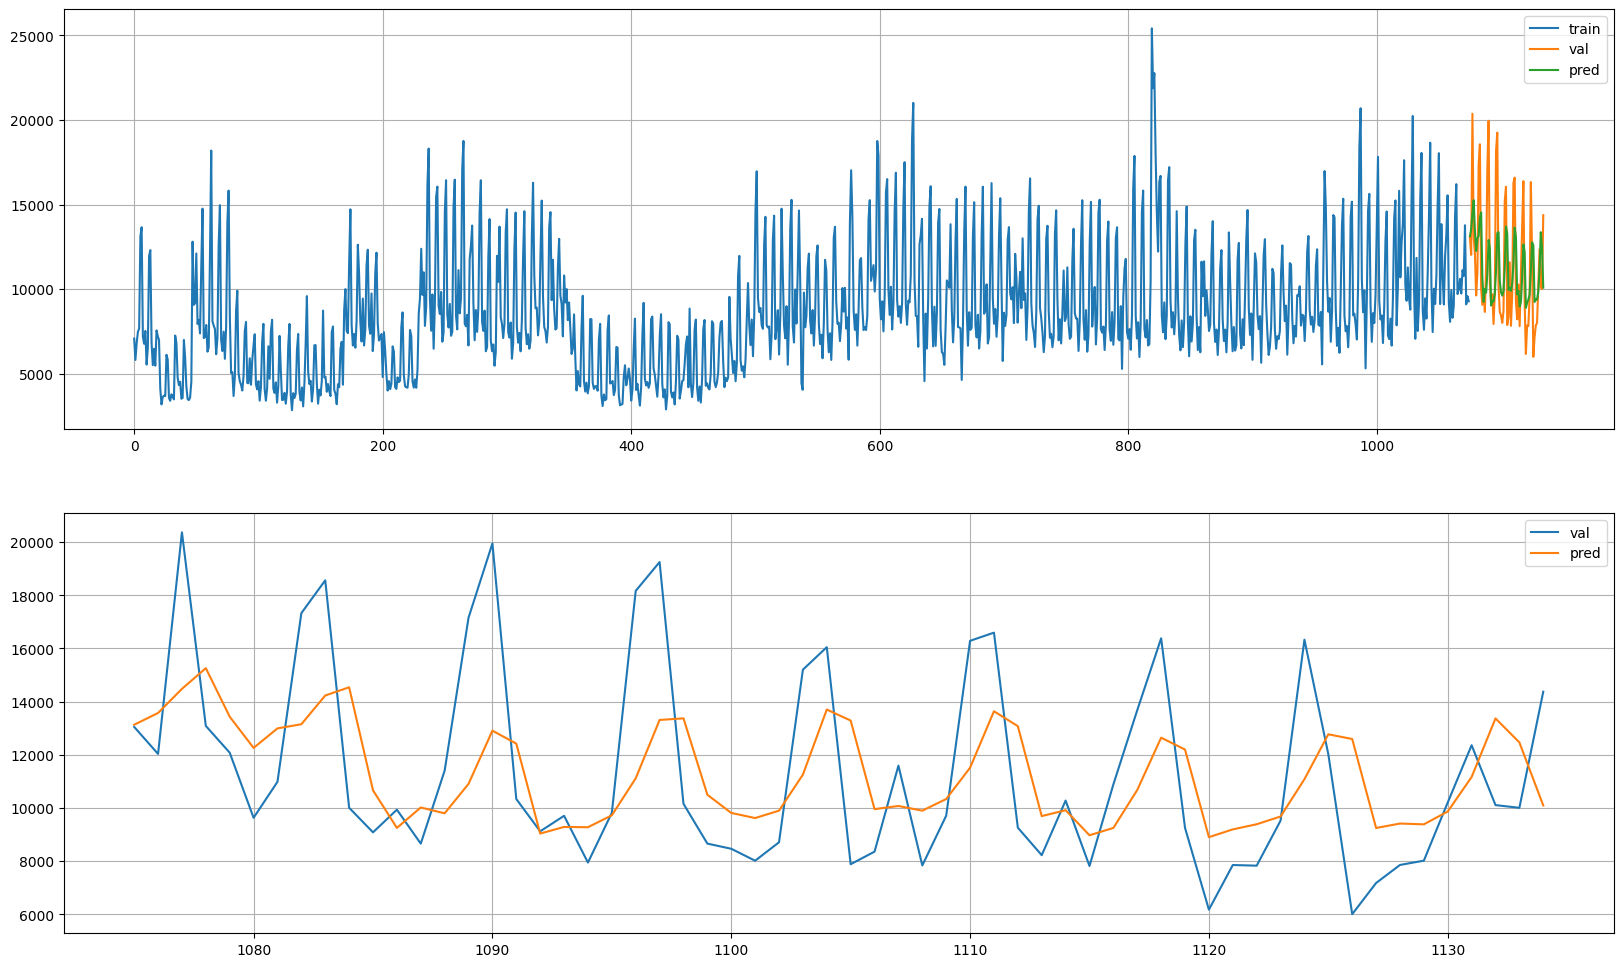

RMSE: 9843595.505686808
MAE: 2528.809423828125
MAPE: 0.22271133183623254
R2: 0.28137451113175926


In [49]:
my_LSTM_model(x_train_b, x_val_b, y_train_b, y_val_b)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [50]:
x_train_m, x_val_m, y_train_m, y_val_m = my_train_test_3(df_milk)

* **모델링**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7)                 532       
                                                                 
 dense (Dense)               (None, 1)                 8         
                                                                 
Total params: 540 (2.11 KB)
Trainable params: 540 (2.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


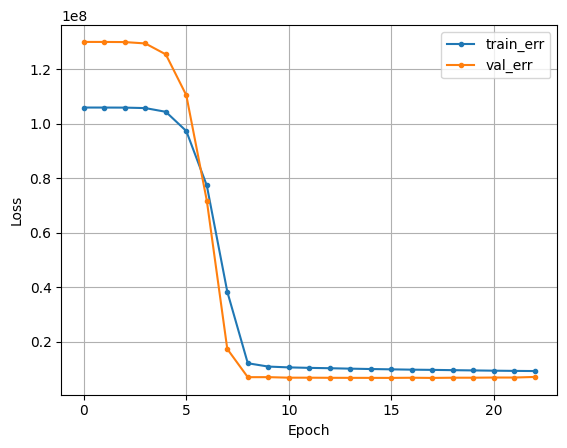

2/2 [==============================] - 0s 7ms/step


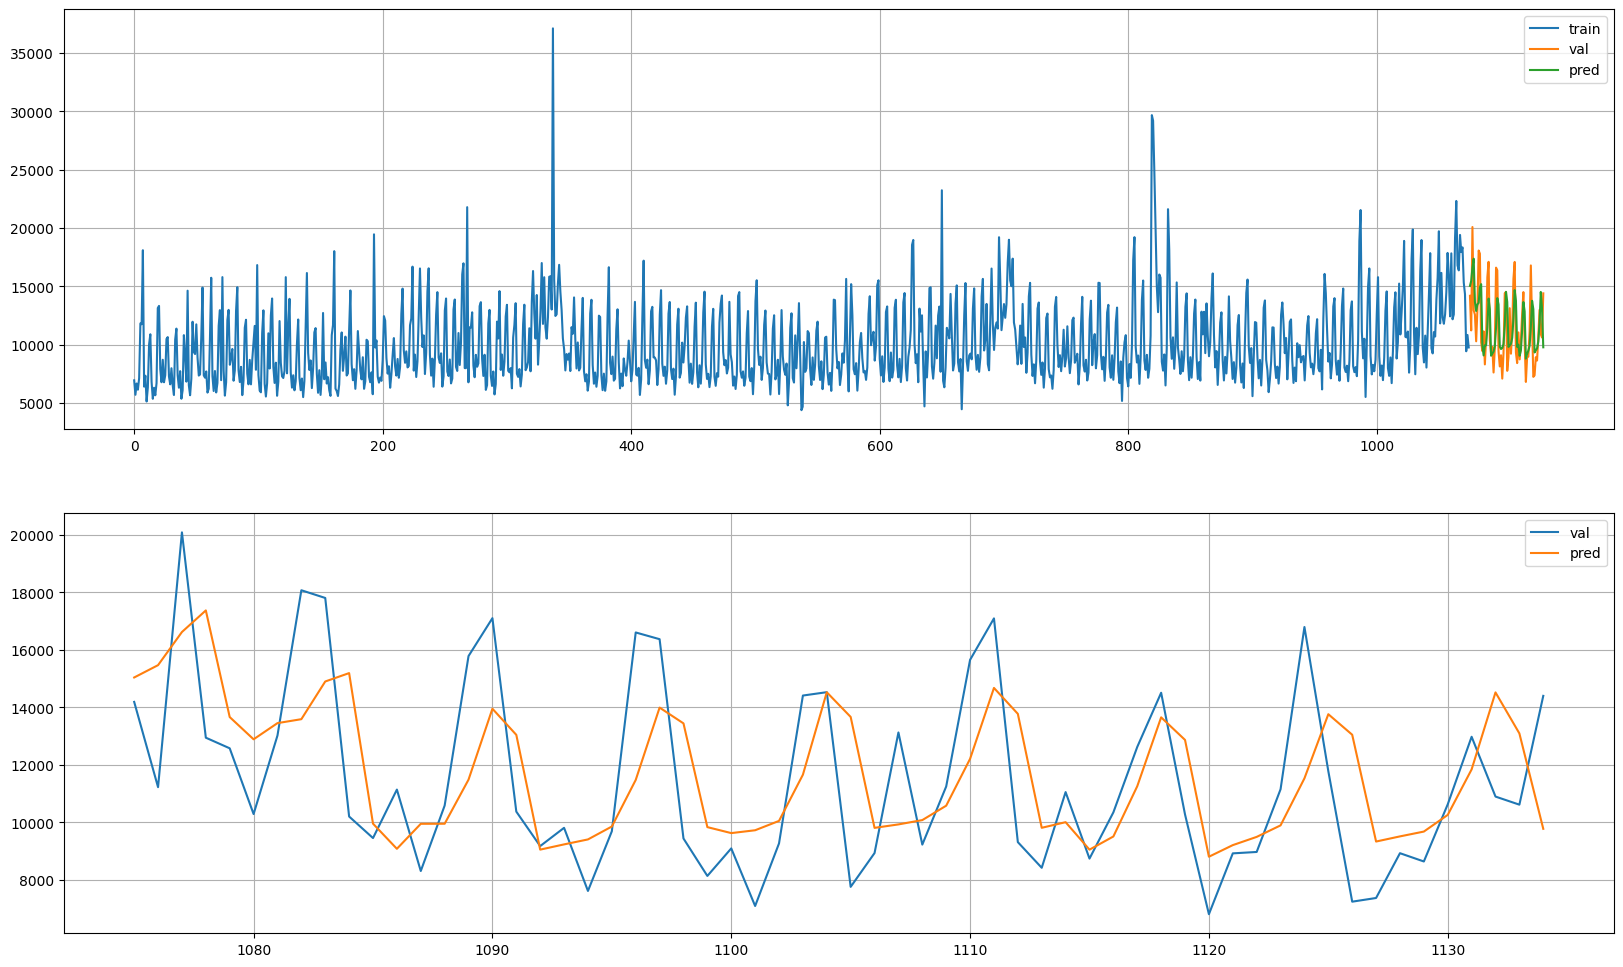

RMSE: 7347134.016561794
MAE: 2168.1242513020834
MAPE: 0.19457599321281963
R2: 0.28456750478541293


In [51]:
my_LSTM_model(x_train_m, x_val_m, y_train_m, y_val_m)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [52]:
x_train_a, x_val_a, y_train_a, y_val_a = my_train_test_3(df_agricultural)

* **모델링**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7)                 532       
                                                                 
 dense (Dense)               (None, 1)                 8         
                                                                 
Total params: 540 (2.11 KB)
Trainable params: 540 (2.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


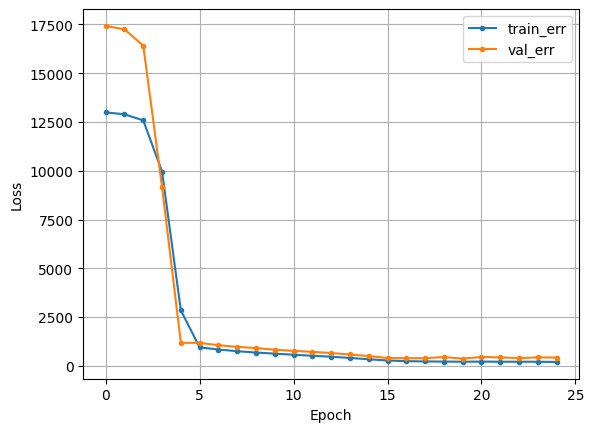

2/2 [==============================] - 0s 7ms/step


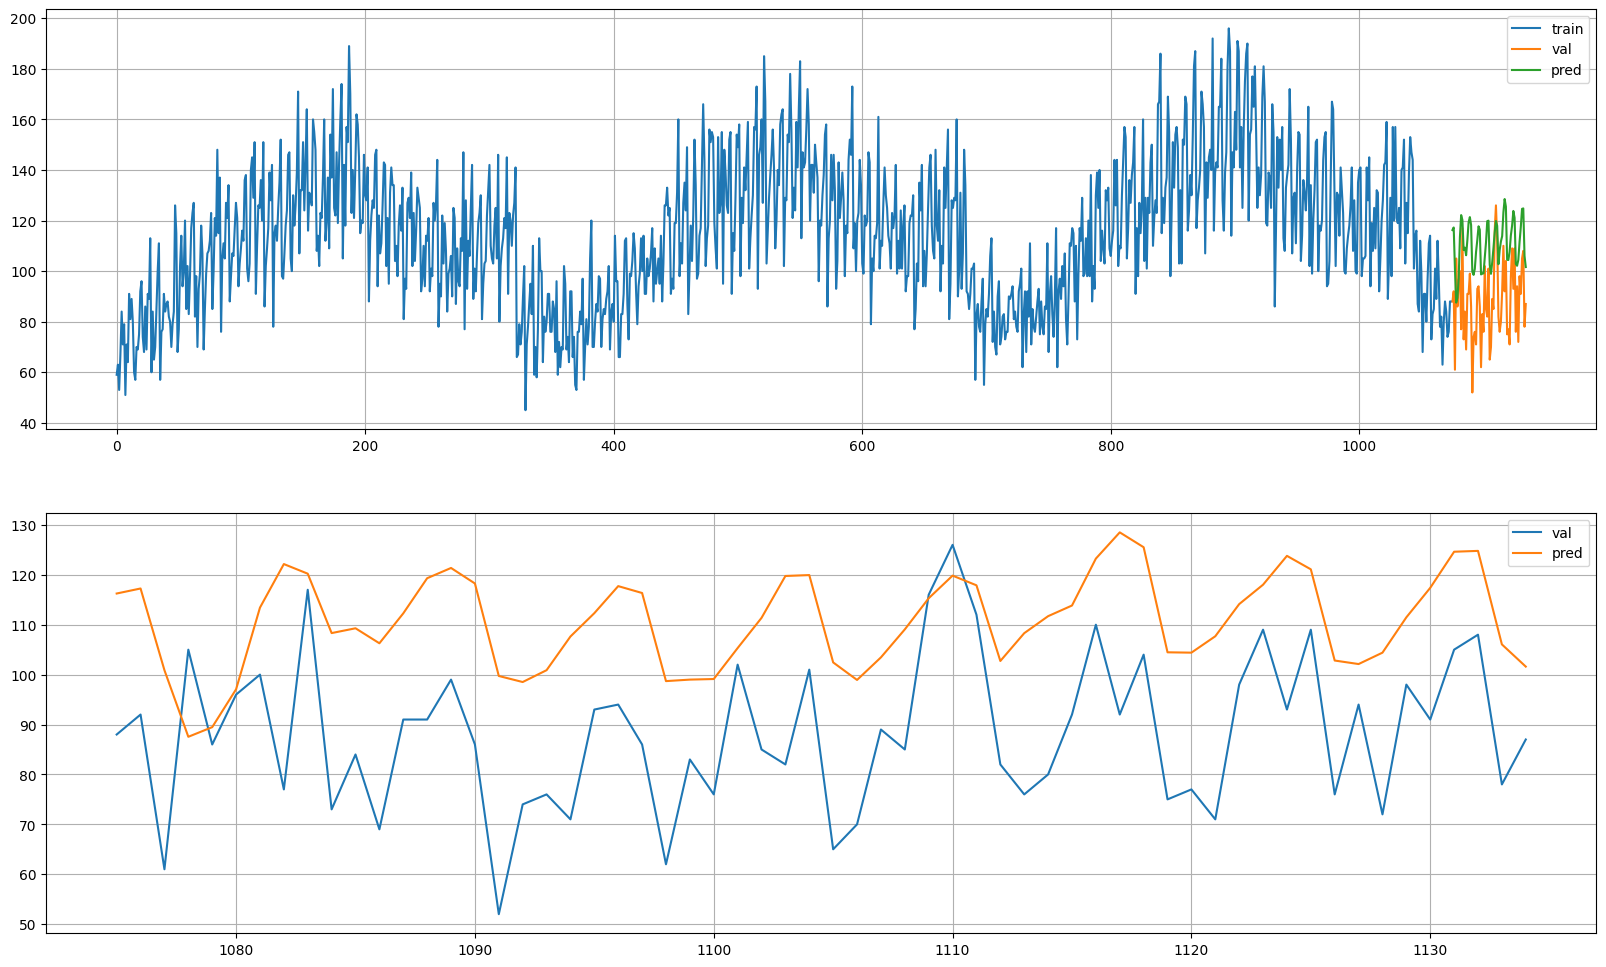

RMSE: 662.9977639267037
MAE: 23.20034344991048
MAPE: 0.289856114705861
R2: -1.8826825296097147


In [53]:
my_LSTM_model(x_train_a, x_val_a, y_train_a, y_val_a)

## **(2) CNN 초기 모델링**

In [54]:
def my_CNN_model(x_train, x_val, y_train, y_val):
    clear_session()

    model = Sequential([
        Input(shape=(x_train.shape[1], x_train.shape[2]))
        , Conv1D(32, 5, activation='relu', padding = 'same')
        , Flatten()
        , Dense(1)
    ])

    model.summary()
    model.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(
        monitor="val_loss"
        , patience=5
        , restore_best_weights=True
    )
    history = model.fit(x_train, y_train, epochs=500, validation_split=.2, callbacks=[es], verbose=0).history
    dl_history_plot(history)
    pred = model.predict(x_val)
    plot_model_result(y_train, y_val, pred)

    print("RMSE:", mean_squared_error(y_val, pred, squared=True))
    print("MAE:", mean_absolute_error(y_val, pred))
    print("MAPE:", mean_absolute_percentage_error(y_val, pred))
    print("R2:", r2_score(y_val, pred))

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [55]:
x_train_b, x_val_b, y_train_b, y_val_b = my_train_test_3(df_beverage)

* **모델링**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 32)             1792      
                                                                 
 flatten (Flatten)           (None, 224)               0         
                                                                 
 dense (Dense)               (None, 1)                 225       
                                                                 
Total params: 2017 (7.88 KB)
Trainable params: 2017 (7.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


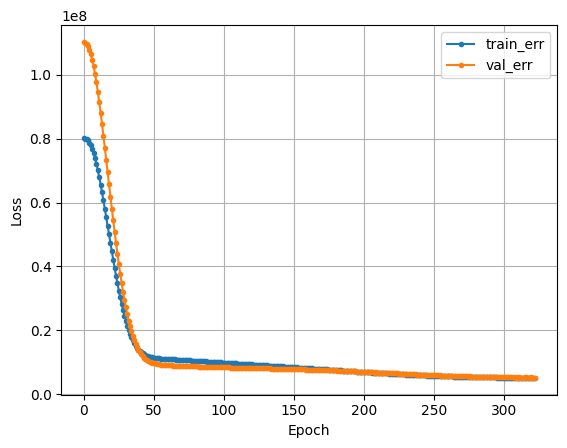

2/2 [==============================] - 0s 6ms/step


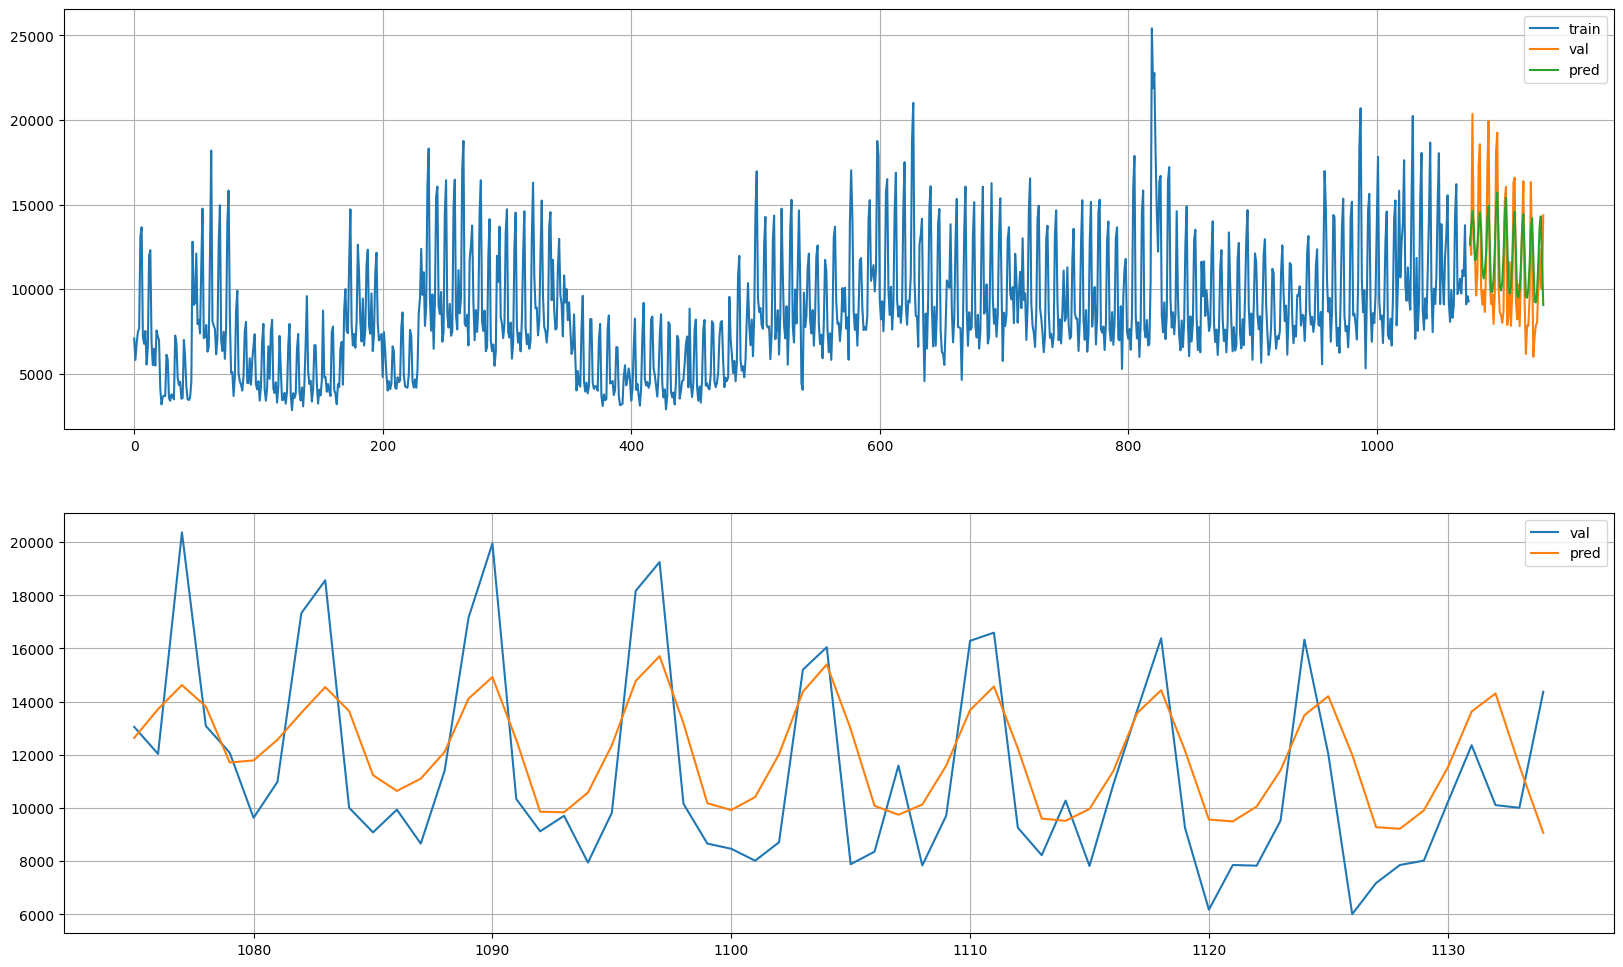

RMSE: 7021047.115014902
MAE: 2265.946875
MAPE: 0.21754774441200944
R2: 0.48743287831365434


In [56]:
my_CNN_model(x_train_b, x_val_b, y_train_b, y_val_b)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [57]:
x_train_m, x_val_m, y_train_m, y_val_m = my_train_test_3(df_milk)

* **모델링**

In [ ]:
my_CNN_model(x_train_m, x_val_m, y_train_m, y_val_m)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 32)             1792      
                                                                 
 flatten (Flatten)           (None, 224)               0         
                                                                 
 dense (Dense)               (None, 1)                 225       
                                                                 
Total params: 2017 (7.88 KB)
Trainable params: 2017 (7.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
x_train_a, x_val_a, y_train_a, y_val_a = my_train_test_3(df_agricultural)

* **모델링**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 32)             1792      
                                                                 
 flatten (Flatten)           (None, 224)               0         
                                                                 
 dense (Dense)               (None, 1)                 225       
                                                                 
Total params: 2017 (7.88 KB)
Trainable params: 2017 (7.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


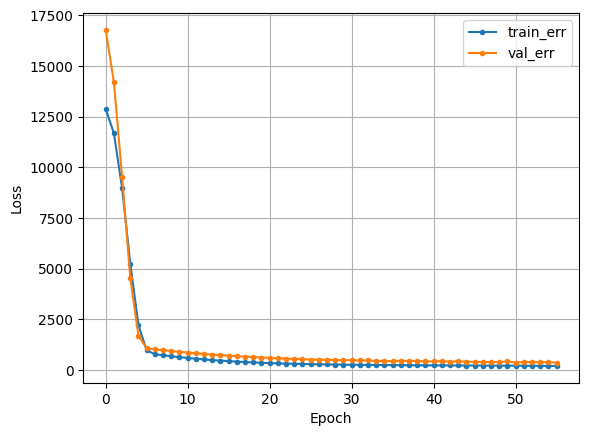

2/2 [==============================] - 0s 5ms/step


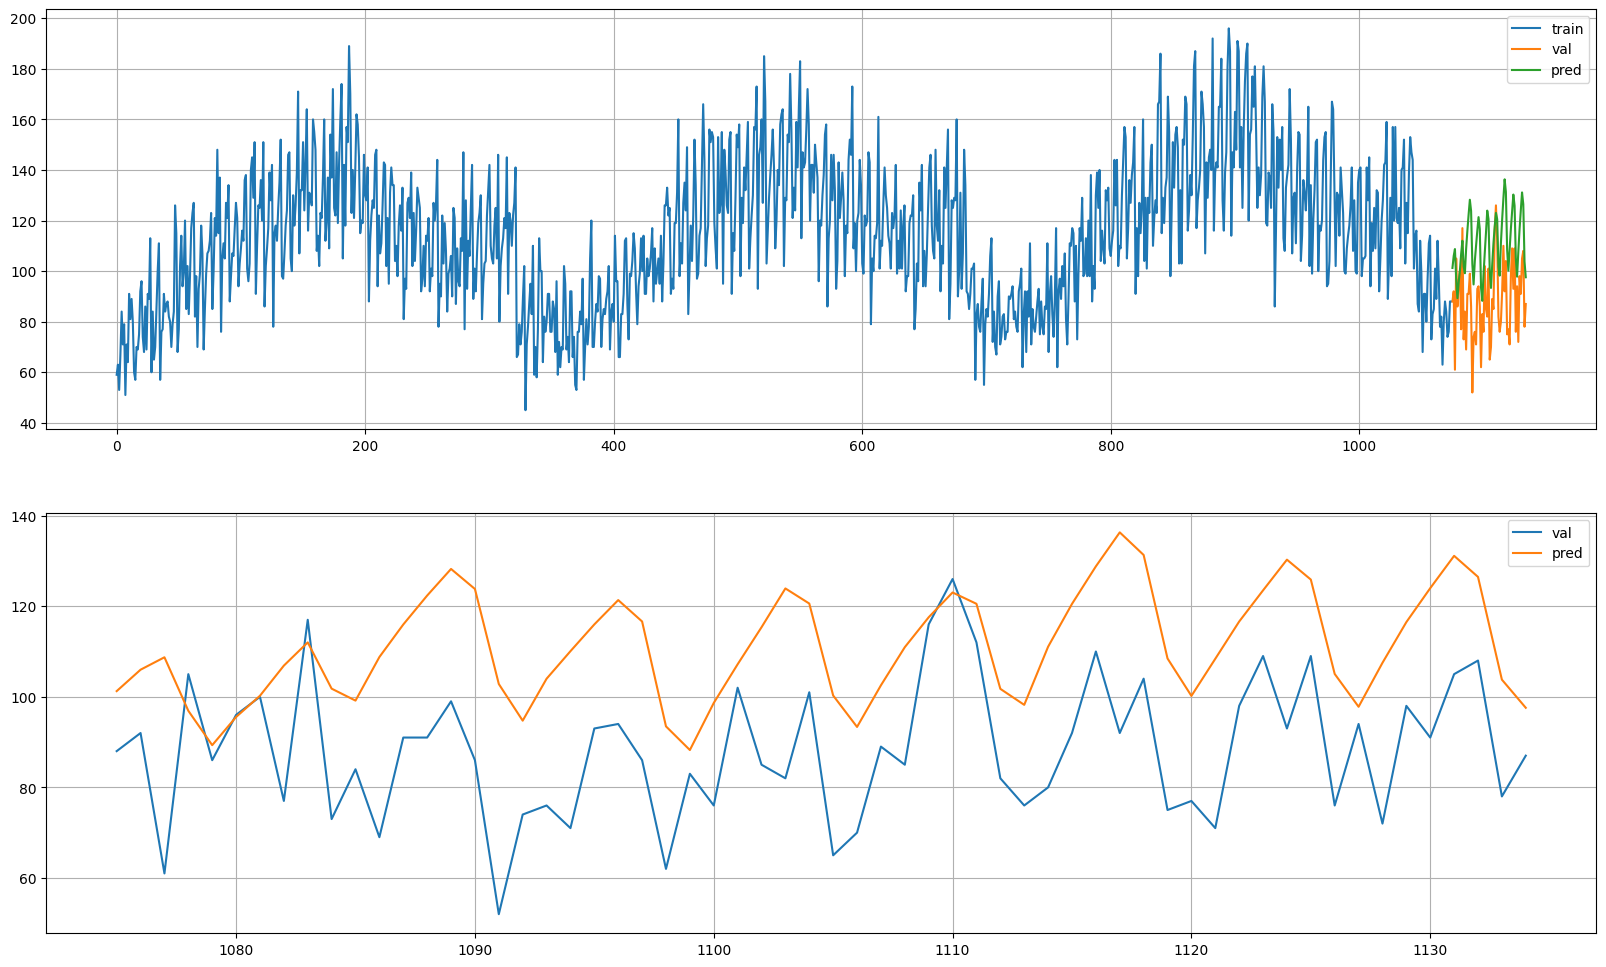

RMSE: 690.2573470475472
MAE: 23.16839714050293
MAPE: 0.28798542758287654
R2: -2.001205891681848


In [ ]:
my_CNN_model(x_train_a, x_val_a, y_train_a, y_val_a)

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
df_beverage.to_pickle('df_beverage.pkl')

In [ ]:
df_milk.to_pickle('df_milk.pkl')

In [ ]:
df_agricultural.to_pickle('df_agricultural.pkl')